## [Lecture 6.2: MNIST Digits Classification using SGDRegressor](https://www.youtube.com/watch?v=wnWmmmjKaTo)

### Introduction
**Recap from MLT**
- Logistic Regression is the **workhorse** of machine learning
- Before Deep learning era, logistic regression was the **default choice** for solving real life classification problems with hundreds of thousands of features.
- It works in binary, multi-class and multi-label classification set ups

### Imports
In this notebook we solve the same problem of recognizing Handwritten digits using logistic regression model.

In [ ]:
# Common imports
import numpy as np
from pprint import pprint

# Sklearn specific imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# Scipy imports
from scipy.stats import loguniform

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Global settings
np.random.seed(42) # To make notebook's output stable across runs
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

In [ ]:
# Ignore all convergence warnings by sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Handwritten Digit Classification
- We are going to use Logistic Regression (despite it's name) to classify given digit image. Again we first apply the model for binary classification and then extend it to multiclass classification.
- Suppose we want to recognize whether the given image is of digit zero or not (digits other than zero). Then the problem could be cast as binary classification problem.
    - The first step is to create a dataset that contains collection of digit images (also called as examples, samples) written by humans. Then each image should be labelled properly.
    - Fortunately, we have a standard benchmark dataset called **MNIST**. Let's import that dataset.

In [ ]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1,return_X_y=True) # Returns the data and label as pandas dataframe

The data matrix $X$ and the respective label vector $y$ need to be converted to numpy array by calling a `to_numpy` method.

In [ ]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

### Preprocessing
- Unlike perceptron, where scaling the range is optional( but recommended), sigmoid requires scaling the feature range between 0 and 1.
- Contemplate the consequences if we don't apply the scaling operation on the input datapoints
- Note: **Do not** apply mean centering as it removes zeros from the data. Zeros should be zeros in the dataset after scaling the data.
- Since we are using only one preprocessing step, using `pipeline` may not be required.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
print('Mean of the features:', np.mean(X))
print('Standard Deviation:', np.std(X))
print('Minimum value:', np.min(X))
print('Maximum value:', np.max(X))

Mean of the features: 0.13092720382627604
Standard Deviation: 0.3084510570135976
Minimum value: 0.0
Maximum value: 1.0


Let's get some information about the dataset. (Note that the labels are of string data type).

In [ ]:
target_names = np.unique(y)
print('Number of samples : {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Number of classes: {0}, type: {1}'.format(len(target_names),y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples : 70000, type: float64
Number of features: 784
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


### Data Visualization
- Let's pick a few images (images have already shuffled in the dataset) and display them with respective labels. As said above, the images are stacked as row vector of size $1 \times 784$ and therefore must be reshaped to matrix of size $28 \times 28$ in order to display them properly.

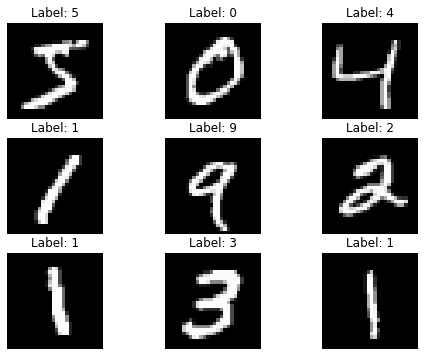

In [ ]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0 # Take "num_images" starting from the index "idx offset"
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Label: {str(y[index+j])}')
        ax[i,j].set_axis_off()

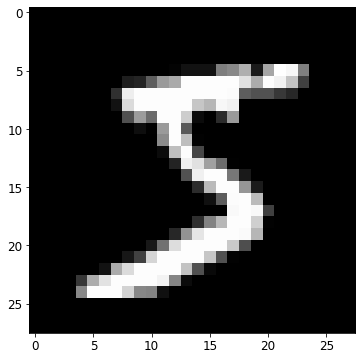

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

### Data Splitting
- Now we know the details such as number of samples, size of each sample, number of features (784), number of classes (targets) about the dataset.
- So let us split the total number of samples into train and test set in the following ratio: 60000/10000 ( that is 60000 samples in the training dataset and 10000 samples in the test set).
- Since the samples in the data set are already randomly shuffled, we dont need to shuffle it again.

In [ ]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeeding further, we need to check whether the data is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.

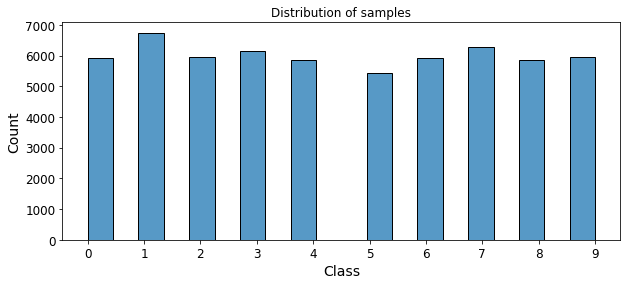

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

### Binary classification : 0-detector

#### Modifying Labels
- Let's start with a simple classification problem, that is binary classification
- Since the original label vector contains 10 classes, we need to modify the number of classes to **2**.
- Therefore, the label **0** will be changed to 1 and all other labels (1-9) will be changed to 0.
- We name the label vectors as `y_train_0` and `y_test_0`.

**(Note: For perceptron we set the negative labels to -1)**

In [ ]:
# Initialize new variable names with all 0
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

#find indices of digit 0 image
indx_0 = np.where(y_train == '0') #remember all the original labels are of type str not int.
#use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

#### Sanity check
Let's display the elements of `y_train` and `y_train_0` whether the labels are properly modified.

In [ ]:
print(y_train) # 10 class labels
print(y_train_0) # modified binary labels

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


In [ ]:
print(np.where(y_train=='0')) # index of label 0's in the original vector y
print(np.where(y_train_0 == 1)) # index of positive class in new vector

(array([    1,    21,    34, ..., 59952, 59972, 59987]),)
(array([    1,    21,    34, ..., 59952, 59972, 59987]),)


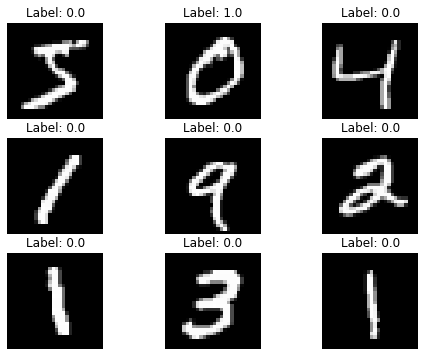

In [ ]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Label: {str(y_train_0[index+j])}')
        ax[i,j].set_axis_off()

#### Baseline Models
Let's quickly construct a baseline model with the following rule (you are free to choose a different rule)
1. Count the number of samples per class
2. The model **always outputs** the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [ ]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == 0)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy='most_frequent') #there are other strategies
base_clf.fit(x_train, y_train_0)
print(f'Training accuracy: {base_clf.score(x_train, y_train_0)}')
print(f'Testing accuracy: {base_clf.score(x_test, y_test_0)}')

Training accuracy: 0.9012833333333333
Testing accuracy: 0.902


- Now the reason is obvious. The model would be predicted 54077 sample correctly just by outputing 0 for all input  samples. Therefore the accuracy will be $\frac{54077}{60000} = 90.12\%$


- This is the reason why accuracy is not a good measure.

### Logistic Regression Model
Before using Logistic Regression for Binary Classification problem, it will be helpful to recall the important concepts (equations) covered in the MLT course.

#### Recap
Let's quickly recap various components in the general settings:
1. **Training Data**: (features, labels) or $(\mathbf{X}, y)$ where $y$ is a **discrete** number from the finite set. **Features** in this case are pixel values of an image.
2. **Model**:
 $$\begin{align}
 z &= w_0x_0 + w_1x_1+w_2x_2+...+w_mx_m \\
 &= \mathbf{w}^T\mathbf{x}
 \end{align}
 $$
 and passing it through the sigmoid non-linear function (or Logistic function).
 $$
 \sigma(z) = \frac{1}{1 + e^{-z}} = \frac{1}{1 + \exp(-z)}
 $$
3. **Loss function**:
$$
\mathbf{J(w)} = -\frac{1}{n} \sum \left[y^{(i)}\log(h_w(\mathbf{x}^{(i)})) + (1 - y^{(i)})(1 - \log(h_w(\mathbf{x}^{(i)}))) \right]
$$
4. **Optimization**: Gradient Descent
- Let's look into the parameters of the `SGDClassifier()` estimator:
```python
class sklearn.linear_model.SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15,
                                            fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, 
                                            verbose=0, epsilon=0.1, n_jobs=None, random_state=None, 
                                            learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, 
                                            validation_fraction=0.1, n_iter_no_change=5 class_weight=None, 
                                            warm_start=False, average=False)
```
- Setting the loss parameter to `loss=log` makes it a logistic regression classifier. We may refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) for more details on the `SGDClassifier` class
- Create an instant of binary classifier (bin_sgd_clf) and call the `fit` method to train the model.
- Let us use fit method of `SGDClassifier()` to plot the iteration vs loss curve (Of course we will use `partial_fit()` method as well).
- Therefore to capture the loss for each iteration during training we set the parameters `warm_start = True` and `max_iter = 1`

#### Training without regularization
- Set `eta0=0.01, learning_rate=constant` and `alpha=0`

In [ ]:
bin_sgd_clf = SGDClassifier(loss='log',
                            penalty='l2',
                            max_iter=1,
                            warm_start=True,
                            eta0=0.01,
                            alpha=0,
                            learning_rate='constant',
                            random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf.fit(x_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

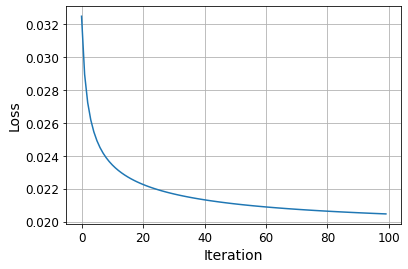

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Let's calculate the training and testing accuracy of the model.

In [ ]:
print('Training accuracy: ', bin_sgd_clf.score(x_train, y_train_0))
print('Test accuracy:', bin_sgd_clf.score(x_test, y_test_0))

Training accuracy:  0.99395
Test accuracy: 0.9919


- We know that accuracy alone is not good enough metric for binary classification.
- Let's compute Precision, recall, F1-score for the model.

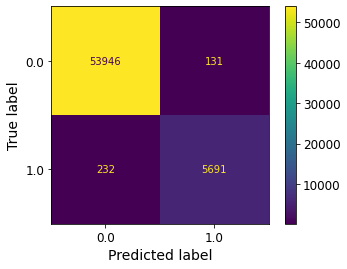

In [ ]:
y_hat_train_0 = bin_sgd_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g') #return matplotlib plot object
plt.show()

In [ ]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [ ]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=100,
                          warm_start=False,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

In [ ]:
cv_bin_clf = cross_validate(estimator, x_train, y_train_0, cv=5,
                            scoring=['precision', 'recall','f1'],
                            return_train_score=True,
                            return_estimator=True)
pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.47793841, 1.47196651, 1.45577621, 1.56206799, 1.26320195]),
 'score_time': array([0.04245448, 0.04820728, 0.04148149, 0.04286027, 0.04263806]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

- From the above result, we can see that logistic regression is better than the perceptron.!
- However, it is good to check the weight values of all the features and decide whether regularizaion could be of any help.

In [ ]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
print('Dimension of weights w: {0}'.format(weights.shape))
print('Bias: {0}'.format(bias))

Dimension of weights w: (1, 784)
Bias: [-4.89282893]


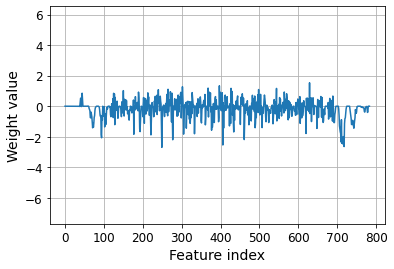

In [ ]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid(True)
plt.show()

- It is interesting to see how many weight values are exactly zero.
- Those features contribute nothing in the classification.

In [ ]:
num_zero_w = weights.shape[-1] - np.count_nonzero(weights)
print('Number of weights with zero value:', num_zero_w)

Number of weights with zero value: 67


#### Training with regularization

In [ ]:
bin_sgd_clf_l2 = SGDClassifier(loss='log',
                                penalty='l2',
                                max_iter=1,
                                warm_start=True,
                                eta0=0.01,
                                alpha=0.001,
                                learning_rate='constant',
                                random_state=1729)
Loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf_l2.fit(x_train, y_train_0)
    y_pred = bin_sgd_clf_l2.predict_proba(x_train)
    Loss.append(log_loss(y_train_0, y_pred))

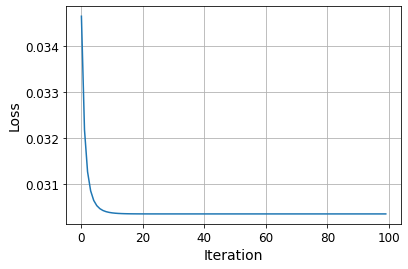

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
print('Bias: {0}'.format(bias))

Bias: [-4.43002876]


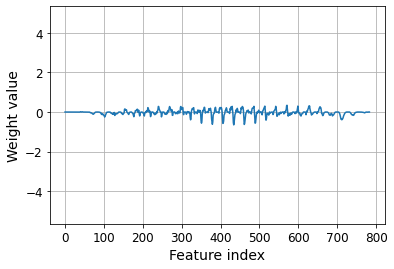

In [ ]:
plt.figure()
plt.plot(np.arange(0,784), weights[0,:])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim((np.min(weights)-5, np.max(weights)+5))
plt.grid(True)
plt.show()

In [ ]:
num_zero_w = weights.shape[-1] - np.count_nonzero(weights)
print('Number of weights with zero value:', num_zero_w)

Number of weights with zero value: 67


In [ ]:
print('Training accuracy: ', bin_sgd_clf_l2.score(x_train, y_train_0))
print('Test accuracy:', bin_sgd_clf_l2.score(x_test, y_test_0))

Training accuracy:  0.9907166666666667
Test accuracy: 0.9905


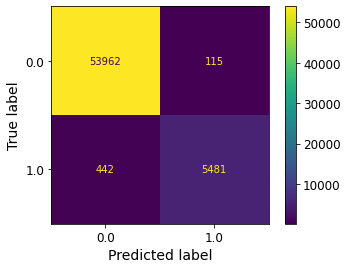

In [ ]:
y_hat_train_0 = bin_sgd_clf_l2.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g') #return matplotlib plot object
plt.show()

In [ ]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### Displaying input image and its prediction

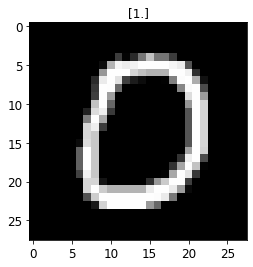

In [ ]:
index = 10 # try some other indices
plt.imshow(x_test[index, :].reshape(28,28), cmap='gray')
pred = bin_sgd_clf_l2.predict(x_test[index].reshape(1,-1))
plt.title(str(pred))
plt.show()

Let's plot a few more images and their respective **predictions** with SGDClassifier without regularization

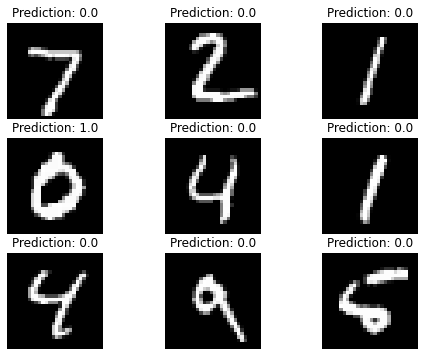

In [ ]:
y_hat_test_0 = bin_sgd_clf.predict(x_test)
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(x_test[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Prediction: {str(y_hat_test_0[index+j])}')
        ax[i,j].set_axis_off()

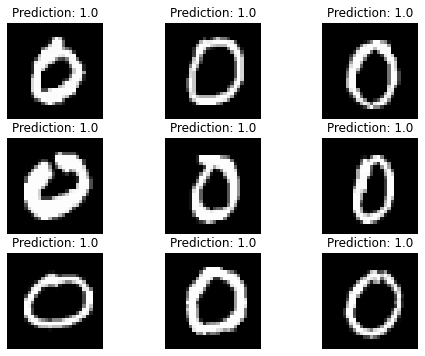

In [ ]:
indx_0 = np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols= factor, figsize=(8,6))
idx_offset = 0
for i in range(factor):
    index =  idx_offset + i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28), cmap='gray')
        ax[i,j].set_title(f'Prediction: {str(zeroLabls[index+j])}')
        ax[i,j].set_axis_off()

#### Hyper-parameter tuning
- We have to use cross validation folds and measure the same metrics across these folds for different values of hyper parameters
- Logistic Regression uses **sgd** solver and hence the learning rate and regularization rate are two import hyper-parameters.
- For a moment, we skip penalizing the parameters and just search for a better learning rate using `RandomizedSearchCV()` and draw the value from uniform distribution.

In [ ]:
lr_grid = loguniform(1e-2, 1e-1)

- Note that `lr_grid` is an object that contains a method called `rvs()` which can be used to get the samples of given size.
- Therefore we pass this `lr_grid` object to the `RandomizedSearchCV()`. Internally it uses `rvs()` method for sampling.

In [ ]:
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [ ]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)

In [ ]:
scores = RandomizedSearchCV(estimator,
                            param_distributions={'eta0':lr_grid},
                            cv=5,
                            scoring=['precision','recall','f1'],
                            n_iter=5,
                            refit='f1')

In [ ]:
# It takes quite a long time to finish
scores.fit(x_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f307c0f63d0>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [ ]:
pprint(scores.cv_results_)

{'mean_fit_time': array([0.4015861 , 0.39365683, 0.3272851 , 0.34584785, 0.3902318 ]),
 'mean_score_time': array([0.04858046, 0.04697261, 0.04554067, 0.05163202, 0.04957519]),
 'mean_test_f1': array([0.95383975, 0.94148246, 0.94869555, 0.95090017, 0.95474878]),
 'mean_test_precision': array([0.96136672, 0.93597638, 0.94998271, 0.9540212 , 0.96640269]),
 'mean_test_recall': array([0.94682062, 0.94851138, 0.94834146, 0.94850966, 0.94361173]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                   0.05395030966670228, 0.039687933304443715,
                   0.01432249371823025],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.02368863950364078},
            {'eta0': 0.08927180304353625},
            {'eta0': 0.05395030966670228},
            {'eta0': 0.039687933304443715},
            {'eta0': 0.01432249371823025}],
 'rank_test_f1': array([2, 5, 4, 3, 1], dtype=int32),


- Let's pick the best estimator from the results

In [ ]:
best_bin_clf = scores.best_estimator_

In [ ]:
y_hat_train_best_0 = best_bin_clf.predict(x_train)

In [ ]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



#### Precision-Recall Tradeoff

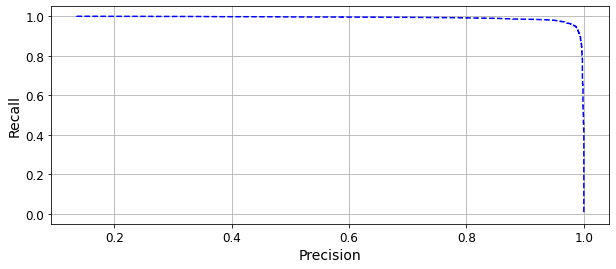

In [ ]:
y_scores = bin_sgd_clf.decision_function(x_train)
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)
plt.figure(figsize=(10, 4))
plt.plot(precisions[:-1], recalls[:-1], 'b--')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

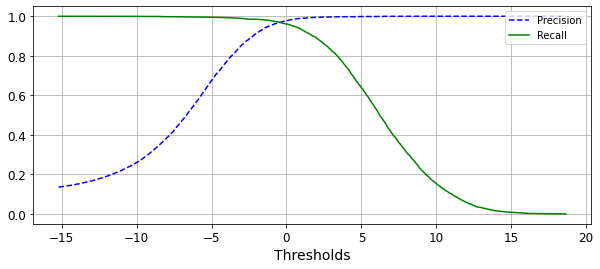

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(thresholds, precisions[:-1], 'b--',label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.xlabel('Thresholds')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### AUC-ROC Curve

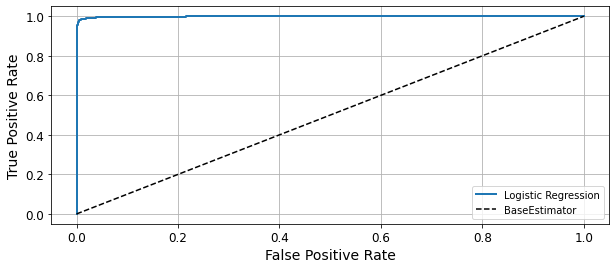

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label='Logistic Regression')
plt.plot([0,1],[0,1],'k--', label='BaseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
auc = roc_auc_score(y_train_0, y_scores)
print('AUC:',auc)

AUC: 0.9984853545995911


## [Lecture 6.3: MNIST Digits Classification using Logistic Regression](https://www.youtube.com/watch?v=Gy-TZWTsKRw)

### Logistic Regression
- In the previous setup, we used `SGDClassifier` to train 0-detector model in an iterative manner.
    - We can also train such a classifier by solving a set of equations by setting the derivative of loss w.r.t weights to 0.
    - These are not linear equations and therefore we need a different solvers.
- Sklearn uses solvers like `liblinear`, `newton-cg`, `sag`, and `lbfgs` to find the optimal weights.
- Regularization is applied by default.
- Parameters:
```python
class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, 
                                                C=1.0, fit_intercept=True, intercept_scaling=1, 
                                                class_weight=None, random_state=None, 
                                                solver='lbfgs', max_iter=100, multi_class='auto', 
                                                verbose=0, warm_start=False, n_jobs=None, 
                                                l1_ratio=None)
```

- Note some of the important default parameters:
    - Regualization: `penalty='l2'`
    - Regularization rate: `C=1`
    - Solver: `solver=lbfgs`
- Let's implement `LogisticRegression()` **without regularization** by setting parameter $C=\infty$. Therefore we may expect performance close to `SGDClassifier` without regularization

### Training without Regularization
- **STEP 1**: Instantiate a pipeline object with two stages.
    - The first stage contains `MinMaxScaler` for scaling the input
    - The second stage contains a `LogisticRegression` classifier with regularization rate `C=np.infty`.
- **STEP 2**: Train the pipeline with feature matrix `x_train` and label_vector `y_train_0`

In [ ]:
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729,
                                                              solver='lbfgs',
                                                              C=np.infty))
pipe_logit.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

By executing this cell, we trained our `LogisticRegression` classifier, which can be used for making predictions on the new inputs.

### Hyper-parameter search

#### with `GridSearchCV`

In the previous cell, we trained `LogisticRegression` classifier with `C=np.infty`. You may wonder if that's the best value for C, as illustration using `GridSearchCV`.
> Note that you can also use `RandomizedSearchCV` for this purpose.

In order to use `GridSearchCV`, we first define a set of values that we want to try out for C. The best value of C will be found from this set.

We define a `Pipeline` object exactly like before with one exception: we have to set parameter value C to 1 in `LogisticRegression` estimator. We can set it to any value as the best value would be searched with grid search.

The additional step here is to instatiate a `GridSearchCV` object with a `Pipeline` estimator, parameter grid specification and `f1` as a `scoring` function.
> Note that you can use other scoring functions like `precision,recall`, however the value of C is found such that given scoring function is optimized.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[('scaler', scaler),
                       ('logistic', logreg)])

pipe_logit_cv = GridSearchCV(pipe,
                             param_grid = {'logistic__C': grid_Cs},
                             scoring='f1')
pipe_logit_cv.fit(x_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

The `GridSearchCV` finds the best value of C and refits the estimator by default on entire training set. This gives us the logistic regression classifier with best value of C.

We can check the value of the best parameter by accessing the `best_params_` member variable of the `GridSearchCV()` object.

In [ ]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

and the best score can be found in `best_score_` member variable and can be obtained as follows:

In [ ]:
pipe_logit_cv.best_score_

0.9579654953103655

The best estimator can be accessed with `best_estimator_` member variable.

In [ ]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

#### With `LogisticRegressionCV`
Instead of using `GridSearchCV` for finding the best value of parameter C, we can use `LogisticRegressionCV` for performing the same job.
- **STEP 1**: Here we make use of `LogisticRegressionCV` estimator with number of cross validation folds `cv=5` and scoring scheme `scoring=f1` in the `Pipeline` object.
- **STEP 2**: In the second step, we train the `Pipeline` object as before.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

By default, `LogisticRegressionCV` refits the model on the entire training set with the best parameter values obtained via cross validation.

### Performance Evaluation

#### Precision, Recall and F1-Score

Let's evaluate performace of these three different regression classifiers for detecting digit 0 from the image.
- Logistic regression without regularization.
- Best logistic regression classifier found through `GridSearchCV`.
- Best classifier found through `LogisticRegressionCV`.
> Note that `GridSearchCV` and `LogisticRegressionCV` by default refit the classifier for best hyperparameter values.

Let's get prediction for test set with these three classifiers.

In [ ]:
lr_y_hat_0 = pipe_logit.predict(x_test)
lr_gs_y_hat_0 = pipe_logit_cv.predict(x_test)
lr_cv_y_hat_0 = logit_cv.predict(x_test)

We will compare **precision, recall** and **F1 score** for the three classifiers.

In [ ]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [ ]:
print(f'LogReg:     Precision={precision_lr}, recall={recall_lr}')
print(f'GridSearch: Precision={precision_lr_gs}, recall={recall_lr_gs}')
print(f'LogRegCV:   Precision-{precision_lr_cv}, recall={recall_lr_cv}')

LogReg:     Precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: Precision=0.9564336372847011, recall=0.963265306122449
LogRegCV:   Precision-0.9546370967741935, recall=0.9663265306122449


Note that all the three classifiers have roughly the same performance as measured with precision and recall
- The `LogisticRegression` classifier obtained through `GridSearchCV` has the highest precision - marginally higher than the other two classifiers.
- The `LogisticRegression` classifier obtained through `LogisticRegressionCV` has the highest recall - marginally higher than the other two classifiers.

#### Using PR-curve

In [ ]:
y_scores_lr = pipe_logit.decision_function(x_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(x_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(x_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

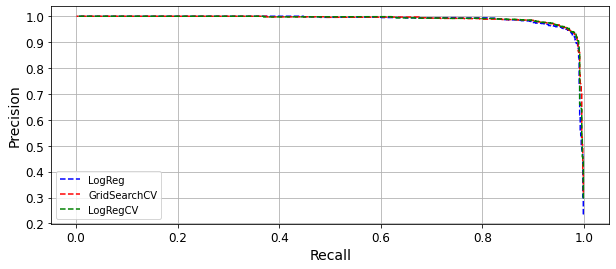

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

Note that the PR curves for all the classifiers overlap significantly

Let's calculate area under the PR curve.

In [ ]:
from sklearn.metrics import auc
auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

In [ ]:
print('AUC-PR for logistic regression:',auc_lr)
print('AUC-PR for grid search:', auc_lr_gs)
print('AUC-PR for logistic regression CV:', auc_lr_cv)

AUC-PR for logistic regression: 0.9871337497759658
AUC-PR for grid search: 0.9886520703587929
AUC-PR for logistic regression CV: 0.9886315347402387


Observe that the AUC for all the three classifier is roughly the same with `LogisticRegression` classifier obtained through cross validation and grid search has slightly higher AUC under PR curve

#### Confusion Matrix

We show a confusion matrix for test set with logistic regression classifier:

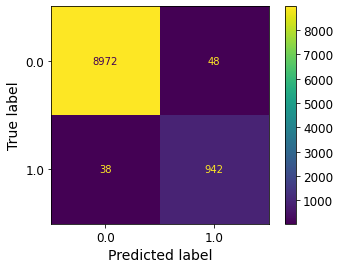

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='.5g')
# it returns a matplotlib plot object
plt.show()

Confusion matrix for test set with logistic regression classifier obtained through **grid search**:

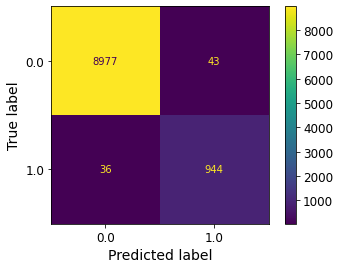

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='.5g')
# it returns a matplotlib plot object
plt.show()

Confusion matrix for test set with logistic regression classifier obtained through **cross validation**:

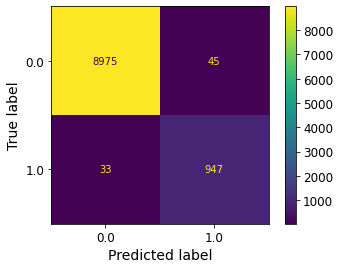

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='.5g')
# it returns a matplotlib plot object
plt.show()

**Exercise**: Plot ROC curve for all three classifiers and calculate area under ROC curve.

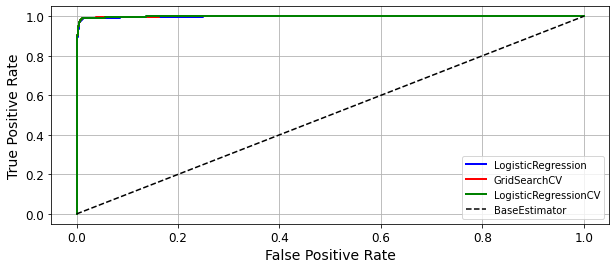

In [ ]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_0, y_scores_lr)
fpr_lr_gs, tpr_lr_gs, thresholds_lr_gs = roc_curve(y_test_0, y_scores_lr_gs)
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test_0, y_scores_lr_cv)


plt.figure(figsize=(10,4))
plt.plot(fpr_lr, tpr_lr, 'b-', linewidth=2, label='LogisticRegression')
plt.plot(fpr_lr_gs, tpr_lr_gs, 'r-', linewidth=2, label='GridSearchCV')
plt.plot(fpr_lr_cv, tpr_lr_cv, 'g-', linewidth=2, label='LogisticRegressionCV')

plt.plot([0,1],[0,1],'k--', label='BaseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
lr_auc_roc = roc_auc_score(y_test_0, y_scores_lr)
print('AUC-ROC for Logistic Regression:',lr_auc_roc)
lr_gs_auc_roc = roc_auc_score(y_test_0, y_scores_lr_gs)
print('AUC-ROC for Grid Search:',lr_gs_auc_roc)
lr_cv_auc_roc = roc_auc_score(y_test_0, y_scores_lr_cv)
print('AUC-ROC for Logistic Regression CV:',lr_cv_auc_roc)

AUC-ROC for Logistic Regression: 0.9980350920856146
AUC-ROC for Grid Search: 0.9985633965337798
AUC-ROC for Logistic Regression CV: 0.9984982352142631


## [Lecture 6.4: Zero detector with Ridge Classifier](https://www.youtube.com/watch?v=qrwPx41Q22c)

### Ridge Classifier
- Ridge Classifier cast the problem as least square classification and finds the optimal weights using some matrix decomposition technique such as SVD
- To train the ridge classifier, the labels should be $y \in \{ +1, -1 \}$
- The Classifier also by default implements l2 regularization. However, we first implement it without regularization by setting `alpha=0`

In [ ]:
# Initialize new variable names with all -1
y_train_0 = -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

#find indices of digit 0 image
indx_0 = np.where(y_train == '0') #remember all the original labels are of type str not int.
#use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

Let's first take a look into the parameters of the class
```python
class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, normalize='deprecated', 
                                           copy_X=True, max_iter=None, tol=0.001, class_weight=None, 
                                           solver='auto', positive=False, random_state=None)
```
Note that the parameter `normalize` is depreciated.

In [ ]:
estimator = RidgeClassifier(normalize=False, alpha=0)
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(x_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

#### Performance

In [ ]:
y_hat_test_0 = pipe_ridge.predict(x_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.95      0.87      0.91       980

    accuracy                           0.98     10000
   macro avg       0.97      0.93      0.95     10000
weighted avg       0.98      0.98      0.98     10000



#### Cross Validation

In [ ]:
cv_bin_ridge_clf = cross_validate(pipe_ridge,
                                  x_train, y_train_0,cv=5,
                                  scoring=['precision','recall','f1'],
                                  return_train_score=True,
                                  return_estimator=True)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([11.54590678, 11.35937953, 12.33841991, 11.94421101, 13.24628782]),
 'score_time': array([0.19063663, 0.10253096, 0.15350628, 0.1171062 , 0.13983583]),
 'test_f1': array([0.90710859, 0.90917108, 0.92334802, 0.904     , 0.90892857]),
 'test_preci

In [ ]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
print(best_estimator_id)

2


In [ ]:
best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

Let's evaluate the performance of the best classifier on the test set.

In [ ]:
y_hat_test_0 = best_estimator.predict(x_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99      9020
         1.0       0.95      0.90      0.93       980

    accuracy                           0.99     10000
   macro avg       0.97      0.95      0.96     10000
weighted avg       0.99      0.99      0.99     10000



### Further Exploration
Let's see what these classifiers learnt about digit 0.

<Figure size 288x288 with 0 Axes>

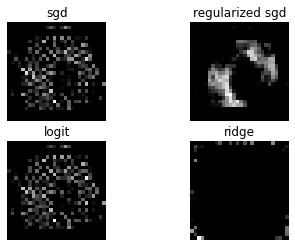

In [ ]:
models = (bin_sgd_clf, bin_sgd_clf_l2, pipe_logit, pipe_ridge)
titles = ('sgd', 'regularized sgd','logit', 'ridge')
plt.figure(figsize=(4, 4))
plt.subplots(2, 2)
for i in range(4):
    if i < 2: # first two models are not pipelines.
        w = models[i].coef_
    else:
        w = models[i][1].coef_ # here 1 represents the index in the pipeline which refers to estimator
    w_matrix = w.reshape(28, 28)
    w_matrix[w_matrix < 0] = 0
    plt.subplot(2, 2, i+1)
    plt.imshow(w_matrix, cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
    plt.grid(False)
fig.show()

## [Lecture 6.5 MultiClass Classifier on MNIST Dataset](https://www.youtube.com/watch?v=v9jAO44KG7M)

### MultiClass Classifier (One vs All)

### MultiClass Logit with SGD

In [ ]:
estimator = SGDClassifier(loss='log',
                          penalty='l2',
                          max_iter=1,
                          warm_start=True,
                          eta0=0.01,
                          alpha=0,
                          learning_rate='constant',
                          random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

In [ ]:
Loss = []
iterations = 100
for i in range(iterations):
    pipe_sgd_ovr.fit(x_train, y_train)
    y_pred = pipe_sgd_ovr.predict_proba(x_train)
    Loss.append(log_loss(y_train, y_pred))

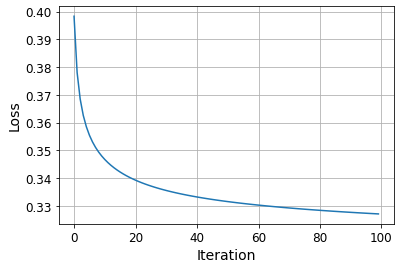

In [ ]:
plt.figure()
plt.plot(np.arange(iterations), Loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

What actually happened behind the screen is that library automatically created 10 binary classifiers and trained them. During the inference time, the input will be passed through all the 10 classifiers and the highest score among the outputs will be considered as the predicted class. To see it in action, let us execute the following lines of code.

In [ ]:
pipe_sgd_ovr[1]

SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=1, random_state=1729, warm_start=True)

In [ ]:
pipe_sgd_ovr[1].coef_.shape

(10, 784)

So its a matrix of size $10 \times 784$. A row represents the weights of a single binary classifier.

In [ ]:
y_hat = pipe_sgd_ovr.predict(x_test)
y_hat[:5]

array(['7', '2', '1', '0', '4'], dtype='<U1')

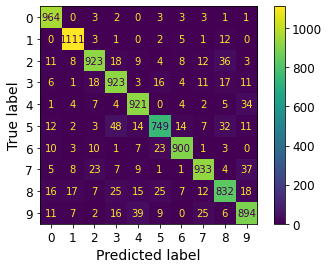

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



In [ ]:
pipe_logit_ovr = make_pipeline(MinMaxScaler(),
                               LogisticRegression(random_state=1729,
                                                  solver='lbfgs',
                                                  C=np.infty))
pipe_logit_ovr.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

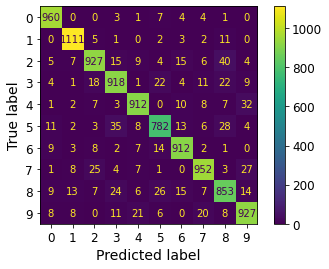

In [ ]:
y_hat = pipe_logit_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



#### Visualize the weight values

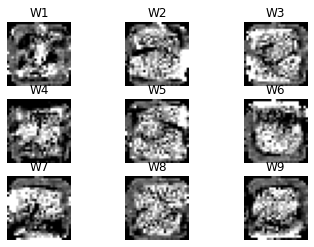

In [ ]:
W = pipe_logit_ovr[1].coef_
#normalize
W = MinMaxScaler().fit_transform(W)
fig, ax = plt.subplots(3, 3)
index = 1
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(W[index,:].reshape(28,28),cmap='gray')
        ax[i][j].set_title('W{0}'.format(index))
        ax[i][j].set_axis_off()
        index += 1

#### Exercise:
MultiClass Classification with RidgeClassifier

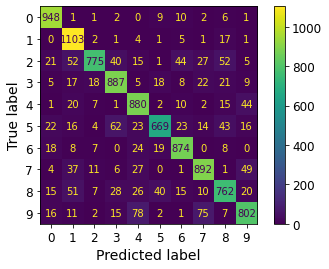

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       980
           1       0.84      0.97      0.90      1135
           2       0.93      0.75      0.83      1032
           3       0.85      0.88      0.86      1010
           4       0.81      0.90      0.85       982
           5       0.88      0.75      0.81       892
           6       0.88      0.91      0.90       958
           7       0.85      0.87      0.86      1028
           8       0.82      0.78      0.80       974
           9       0.85      0.79      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



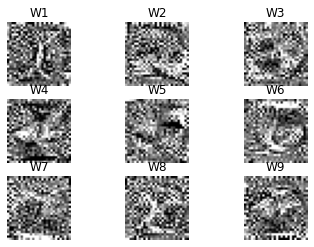

In [ ]:
#RidgeClassifier without regularization
estimator = RidgeClassifier(normalize=False, alpha=0)
pipe_ridge_ovr = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge_ovr.fit(x_train, y_train)

y_hat = pipe_ridge_ovr.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='.5g')
plt.show()

print(classification_report(y_test, y_hat))

W = pipe_ridge_ovr[1].coef_
#normalize
W = MinMaxScaler().fit_transform(W)
fig, ax = plt.subplots(3, 3)
index = 1
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(W[index,:].reshape(28,28),cmap='gray')
        ax[i][j].set_title('W{0}'.format(index))
        ax[i][j].set_axis_off()
        index += 1

## [Lecture 6.6: Naive Bayes Classifier](https://www.youtube.com/watch?v=eyPYs5jJFys)

### Text Classification with Naive Bayes Classifier
In this notebook, we will use Naive Bayes Classifier for classifying text.

Naive Bayes classifier is used for text classification and spam detection tasks.

Here's an example as how to perform the text classification with Naive Bayes classifier.

In [ ]:
# Data loading
from sklearn.datasets import fetch_20newsgroups

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Model/Estimator
from sklearn.naive_bayes import MultinomialNB

# Pipeline utility
from sklearn.pipeline import make_pipeline

# Model evaluation
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting library
import matplotlib.pyplot as plt

**Exercise**: Read about [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) API.

#### Dataset
We will be using 20 newsgroup data set for classification.

As a first step, let's download 20 newsgroup dataset with `fetch_20newsgroups` API

In [ ]:
data = fetch_20newsgroups()

Let's look at the names of classes.

In [ ]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

There are **20 categories** in the dataset. For simplicity, we will select **4** of these categories and download training and test sets.

In [ ]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space','comp.graphics']
train = fetch_20newsgroups(subset='train',categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

Let's look at the sample training document:

In [ ]:
print(train.data[5])

From: dmcgee@uluhe.soest.hawaii.edu (Don McGee)
Subject: Federal Hearing
Originator: dmcgee@uluhe
Organization: School of Ocean and Earth Science and Technology
Distribution: usa
Lines: 10


Fact or rumor....?  Madalyn Murray O'Hare an atheist who eliminated the
use of the bible reading and prayer in public schools 15 years ago is now
going to appear before the FCC with a petition to stop the reading of the
Gospel on the airways of America.  And she is also campaigning to remove
Christmas programs, songs, etc from the public schools.  If it is true
then mail to Federal Communications Commission 1919 H Street Washington DC
20054 expressing your opposition to her request.  Reference Petition number

2493.



This data is different than from what we have seen so far. Here's the training data contains document in text form.

As we have mentioned this in the first week of machine learning techniques course, we need to convert the data to numeric form.

`TfidVectorizer` is one such API that converts text input into a vector of numerical values.

We will be using multinomial Naive Bayes classifier for categorizing documents from 20newsgroups corpus.

In [ ]:
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Let's train the model

In [ ]:
model.fit(train.data, train.target)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

#### Model evaluation
Let's first predict the labels for the test set and then calculate the confusion matrix for the test set.

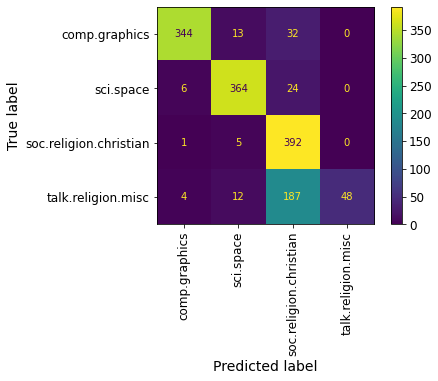

In [ ]:
cm_display = ConfusionMatrixDisplay.from_estimator(model,
                                                   test.data, test.target,
                                                   display_labels=test.target_names,
                                                   xticks_rotation='vertical')
plt.show()

Observe that:
- There is a confusion between the documents of class `soc.religion.christian` and `talk.religion.misc`, which is along the expected lines.
- The classes `comp.graphics` and `sci.space` are well separated by such a simple classifier.

Now we have a tool to classify statements into one of these four classes.
> Make use of `predict` function on pipeline for predicting category of test string.

In [ ]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Using this function for prediction:

In [ ]:
predict_category('Sending a payload to the ISS')

'sci.space'

In [ ]:
predict_category('Discussing islam vs atheism')

'soc.religion.christian'

In [ ]:
predict_category('Determining the screen resolution')

'comp.graphics'